A notebook used to show how to collect images and label images (using Label Studio) for semantic segmentation.

The dataset to be used here is [The Oxford-IIIT Pet Dataset](https://www.robots.ox.ac.uk/~vgg/data/pets/).

# Imports

In [31]:
# for math operations
import numpy as np
# for file system operations
import os
# for image operations
import cv2
# for moving/copying files
import shutil
# using paths.list_images to get all images in a folder
from imutils import paths
# for random functions
import random
# for splitting dataset
from sklearn.model_selection import train_test_split

# Setup Config

In [2]:
# define the directory to save your images into
DATASET_DIR = "dataset"

# define the directory to save all images
IMAGE_DIR = os.path.join(DATASET_DIR, 'images')

# define the directory to the mask images
# the 'trimaps' folder specified here is based on the dataset that we will use later
MASK_DIR = os.path.join(DATASET_DIR, 'annotations', 'trimaps')

# defining the class names for the dataset
CLASS_NAMES = ["cat"]

# Set the image size that we want to save them with
IMAGE_SIZE = (320, 320)

In [3]:
# Setup training, validation and testing paths
TRAIN_PATH = os.path.join(DATASET_DIR, "training")
VAL_PATH = os.path.join(DATASET_DIR, "validation")
TEST_PATH = os.path.join(DATASET_DIR, "testing")

In [4]:
# Set up the splitting ratio for the 3 separate sets
TEST_SPLIT = 0.1
VAL_SPLIT = 0.1
TRAIN_SPLIT = 1.0 - TEST_SPLIT - VAL_SPLIT
TRAIN_SPLIT

0.8

# Setup Dataset

The dataset used for demo here is The Oxford-IIIT Pet Dataset, you may refer to the details in their [website here](https://www.robots.ox.ac.uk/~vgg/data/pets/). 

But the download link for the images in the website is not working for some reason, so please proceed to download the images [from here](http://www.robots.ox.ac.uk/~vgg/data/pets/data/images.tar.gz) instead to follow the steps used in this notebook. Also, download the annotations [from here](https://www.robots.ox.ac.uk/~vgg/data/pets/data/annotations.tar.gz).

After you have downloaded them, there should be two tar files: `images.tar_2.gz` and `annotations.tar.gz`. Please move both of them into the **same directory** as this notebook (same as the root directory of this code repository). If you are on Windows, simply unzipping the images tar file seems to not work. Therefore, untar the files using the code cell below instead.

In [8]:
!tar -xf images.tar_2.gz
!tar -xf annotations.tar.gz

In [13]:
# then move them into the dataset folder
shutil.move("images", DATASET_DIR)
shutil.move("annotations", DATASET_DIR)

'dataset\\annotations'

# Check images

This code cell below check and verify that the images are usable for loading and training. This is useful especially in case you are collecting all images on your own.

If you found any errors with any of the images, it's better to just remove them to avoid unnecessary errors.

In [20]:
from skimage import io
from imutils import paths
import cv2

# NOTE: Change this to your desired path
IMAGE_PATH_TO_CHECK = IMAGE_DIR
image_paths = list(paths.list_images(IMAGE_PATH_TO_CHECK))
print(f'[INFO] Checking {len(image_paths)} images ...')

error_img_paths = []
for img_path in image_paths:
    try:
        # To check if the images can be loaded
        io_img = io.imread(img_path)
        cv_img = cv2.imread(img_path)
        if io_img is None:
            raise Exception("Image unreadable with io.imread")
        if cv_img is None:
            raise Exception("Image unreadable with cv2.imread")
    except Exception as e:
        print(e)
        print(img_path)
        error_img_paths.append(img_path)
        
if error_img_paths:
    print(f"[INFO] {len(error_img_paths)} images with error!")
else:
    print("[INFO] All images ok")

[INFO] Checking 7390 images ...
Image unreadable with cv2.imread
dataset\images\Abyssinian_34.jpg
Image unreadable with cv2.imread
dataset\images\Egyptian_Mau_139.jpg
Image unreadable with cv2.imread
dataset\images\Egyptian_Mau_145.jpg
Image unreadable with cv2.imread
dataset\images\Egyptian_Mau_167.jpg
Image unreadable with cv2.imread
dataset\images\Egyptian_Mau_177.jpg
Image unreadable with cv2.imread
dataset\images\Egyptian_Mau_191.jpg
[INFO] 6 images with error!


For this Oxford Pet dataset, there are 6 images that cannot be read with OpenCV. I removed them using the cell below before proceeding.

For other datasets, if you found any images with error, consider removing them before proceeding.

In [21]:
for img_path in error_img_paths:
    os.remove(img_path)
print(f"[INFO] Successfully removed {len(error_img_paths)} images" )

[INFO] Successfully removed 6 images


# Image Labelling with Label Studio

This section will only show how to label with Label Studio in case you need to label them by yourself. I will not be labeling a complete dataset this time as it is very time-consuming especially for image segmentation labels.

NOTE: For this example in this notebook, I will only demonstrate for 5 images, and also how to prepare the annotation mask images to use for training.

1. Open Anaconda prompt and activate your environment with `conda activate tfod` (my environment name is `tfod`)
2. Then run Label Studio by entering `label-studio`
3. Create a local account to be used (if never create before), please do not forget the email and the password
4. Click "Create" button at top right to create a new project
5. Enter a project name such as "Pet Segmentation test" and click the "Save" button
6. Click the "Go to import"
7. Go to your images folder and drag all the images into Label Studio and click "Import". If you just want to follow the example in this notebook, then drag only the first 5 images (Abyssinian_1 until Abyssinian_5) from the `images` folder into Label Studio.
8. Click "Label All Tasks" and you will be prompted to set up labeling configuration
9. Click "Go to setup" > "Browse Templates" > "Computer Vision" > "Semantic Segmentation with Polygons"
10. Delete both the existing labels ("Airplane" and "Car") by clicking the red "X" beside them
11. Add your label names by typing into the textbox under "Add label names" (in this example we only add a "cat" label), and click "Add" > "Save"
12. Now click "Label all tasks" and start labeling the polygons! 
13. Select the **class** such as 'cat' and draw the polygons. Make sure to draw them as tight as possible (one of the best practices). See an example shown below.
14. After labelling each image, click the "Submit" at the right and continue until the Label Studio says you have finished labeling all images. If you don't want to finish labeling all images in one go, you can close the window and the terminal and continue labeling next time, the labeling progress will always be saved locally.
15. Finally, click the "Export" at the top right and **make sure** to select **"COCO"** before clicking "Export". Then you are done with the tedious labeling process!

<img src="images/sample-label.png" width=500></img>


Best practices on how to label images properly:
1. Label every object of interest in every image
2. Label the entirety of an object **tightly** and not cutting off parts of the object
3. Label occluded objects as if they were fully visible
4. Create specific label names that are not too general

Refer to the [link here](https://blog.roboflow.com/tips-for-how-to-label-images/) for more details.

# Creating sample mask images

After you have exported the dataset from Label Studio, you should see a `zip` file at your `Downloads` folder in your PC. Unzip the data and copy the contents into a folder named "sample_dataset" in the root directory of this project. Then run the cell below to check. There should be an `images` folder and a `result.json` file.

In [93]:
SAMPLE_DIR = "sample_dataset"
os.listdir(SAMPLE_DIR)

['images', 'masks', 'result.json']

In [94]:
SAMPLE_MASK_DIR = os.path.join(SAMPLE_DIR, "masks")
if not os.path.exists(SAMPLE_MASK_DIR):
    print(f"[INFO] creating directory '{SAMPLE_MASK_DIR}'")
    os.makedirs(SAMPLE_MASK_DIR)

In [12]:
import json
from pycocotools.coco import COCO
import numpy as np
import cv2
from skimage import io
import matplotlib.pyplot as plt
from IPython.display import display

# set this to show matplotlib figures in Jupyter outputs
%matplotlib inline

def getClassName(classID):
    if classID <= len(CLASSES) - 1:
        return CLASSES[classID]
    raise ValueError(f"The given class ID '{classID}' is not found.")

json_path = os.path.join(SAMPLE_DIR, 'result.json')
json_file = json.loads(open(json_path).read())
img_dict_list = json_file["images"]
annotations = json_file["annotations"]

print(img_dict_list[0].keys())
print(annotations[0].keys())

dict_keys(['width', 'height', 'id', 'file_name'])
dict_keys(['id', 'image_id', 'category_id', 'segmentation', 'bbox', 'ignore', 'iscrowd', 'area'])


In [6]:
# https://towardsdatascience.com/master-the-coco-dataset-for-semantic-image-segmentation-part-1-of-2-732712631047
coco = COCO(json_path)
catIDs = coco.getCatIds()
categories = coco.loadCats(catIDs)
print(f"\n{categories = }")
CLASSES = [i["name"] for i in categories]
# add a background class at index 0
CLASSES = ["background"] + CLASSES
print(f"{CLASSES = }")

loading annotations into memory...
Done (t=0.00s)
creating index...
index created!

categories = [{'id': 0, 'name': 'cat'}]
CLASSES = ['background', 'cat']


<br>

NOTE: Set the `IS_CHECKING` variable below to `True` to see the output images first. Then set it to `False` to save the mask images to be used for training. These mask images are not generated by Label Studio, so we have to generate them ourselves here to be able to use them for training for semantic segmentation.

In [95]:
# Set to True to check several images with masks overlayed
# Set to False to save the mask images
IS_CHECKING = False
SHOW_COCO_MASKS = True
FIGSIZE = (10, 5)

In [165]:
for i, img_dict in enumerate(img_dict_list):
    img_path = os.path.join(SAMPLE_DIR, img_dict["file_name"])
    filename = os.path.basename(img_path)

    annIds = coco.getAnnIds(imgIds=img_dict["id"], catIds=catIDs, iscrowd=None)
    anns = coco.loadAnns(annIds)
    
    if IS_CHECKING and SHOW_COCO_MASKS:
        print("[INFO] Showing masks using coco.showAnns ...")
        img = io.imread(img_path)
        plt.imshow(img)
        plt.title(filename)
        coco.showAnns(anns)
        plt.show()

    mask = np.zeros((img_dict["height"], img_dict["width"]))
    classes_found = []
    for annot in anns:
        # considering 'background' class at index 0
        className = getClassName(annot["category_id"] + 1)
        classes_found.append(className)
        pixel_value = CLASSES.index(className)
        # the final mask contains the pixel values for each class
        mask = np.maximum(coco.annToMask(annot) * pixel_value, mask)

    if not IS_CHECKING:
        # save the mask images as PNG to save the mask pixel values correctly
        # saving in JPG would result in different pixel values being saved
        mask_path = os.path.join(SAMPLE_MASK_DIR, filename.replace("jpg", "png"))
        print(f"{mask.shape =}")
        print(f"{np.unique(mask) = }")
        cv2.imwrite(mask_path, mask)
        print(f"[INFO] Saved mask image to {mask_path}\n")
    else:
        if i == 5:
            # stop after checking at most 5 images
            break

        # show original and grayscale mask side by side
        print("[INFO] Showing original and mask images ...")
        print(
            f"{filename} | "
            f"Unique pixel values = {np.unique(mask)} | "
            f"Classes found = {classes_found}\n"
        )
        print("Press any key to continue to next image, or press 'ESC' to exit\n")
        img = cv2.imread(img_path)
        cv2.imshow(f"Original image", img)
        cv2.imshow(f"Mask", mask)
        key = cv2.waitKey(0)
        cv2.destroyAllWindows()
        if key == 27:
            # press 'ESC' key to exit
            break

mask.shape =(400, 600)
np.unique(mask) = array([0., 1.])
[INFO] Saved mask image to sample_dataset\masks\Abyssinian_1_53x6lYo.png

mask.shape =(473, 600)
np.unique(mask) = array([0., 1.])
[INFO] Saved mask image to sample_dataset\masks\Abyssinian_2_J4dXvrx.png

mask.shape =(869, 600)
np.unique(mask) = array([0., 1.])
[INFO] Saved mask image to sample_dataset\masks\Abyssinian_3_J8YIOPc.png

mask.shape =(500, 335)
np.unique(mask) = array([0., 1.])
[INFO] Saved mask image to sample_dataset\masks\Abyssinian_4.png

mask.shape =(150, 200)
np.unique(mask) = array([0., 1.])
[INFO] Saved mask image to sample_dataset\masks\Abyssinian_5.png



# Checking the newly created masks

In [166]:
from imutils.paths import list_images
sample_mask_path = list(list_images(SAMPLE_MASK_DIR))[0]
sample_mask_path

'sample_dataset\\masks\\Abyssinian_1_53x6lYo.png'

Abyssinian_1_53x6lYo.png


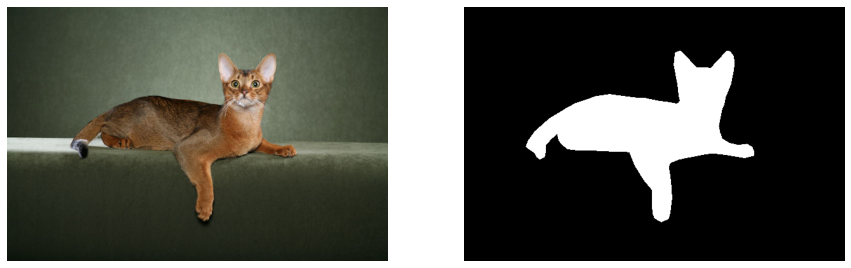

In [168]:
filename = os.path.basename(sample_mask_path)
image_path = os.path.join(SAMPLE_DIR, "images", filename.replace("png", "jpg"))
img = cv2.imread(image_path)
# convert to RGB to show correct colors with matplotlib
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
mask = cv2.imread(sample_mask_path, cv2.IMREAD_GRAYSCALE)

print(filename)
plt.figure(figsize=(15, 10))
plt.subplot(121)
plt.axis('off')
plt.imshow(img)

plt.subplot(122)
plt.imshow(mask, cmap='gray')
plt.axis('off')
plt.show()

<br>

Let's check the mask pixel values to confirm that the saved and loaded mask images retain the same pixel values.

These unique pixels values are very important to represent different classes, where pixel value of 0 USUALLY represents background, sometimes people might use different pixel values to represent background, which is the case with the Oxford Pet dataset, as shown later.

To make things work for semantic segmentation, always make sure there is a background (generally 0) pixel value and a unique pixel value for each class.

NOTE: The mask pixel values should start at 0 for the segmentation model to understand when training. If it doesn't, you must modify them to start from 0. An example will be shown with the original mask images provided from Oxford Pet dataset.

In [169]:
# 0 for background, 1 for cat in this image
np.unique(mask)

array([0, 1], dtype=uint8)

# Showing image and mask obtained from Oxford Pet Dataset

Image: Abyssinian_1.jpg | Mask: Abyssinian_1.png


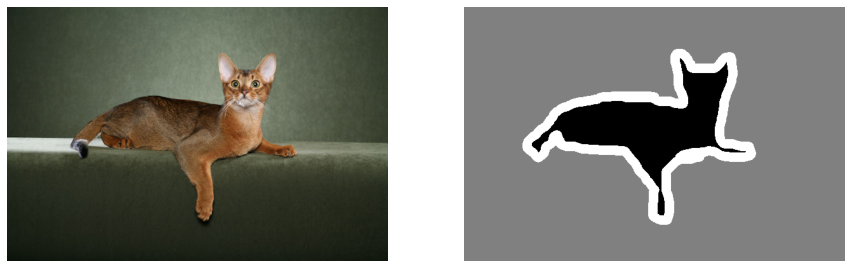

In [178]:
mask_path = os.path.join(MASK_DIR, "Abyssinian_1.png")
filename = os.path.basename(mask_path)

image_name = filename.replace("png", "jpg")
image_path = os.path.join(DATASET_DIR, "images", image_name)
img = cv2.imread(image_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

print(f"Image: {image_name} | Mask: {filename}")
plt.figure(figsize=(15, 10))
plt.subplot(121)
plt.axis('off')
plt.imshow(img)

plt.subplot(122)
plt.imshow(mask, cmap='gray', vmin=1, vmax=3)
plt.axis('off')
plt.show()

The problem with Oxford Pet dataset is that the masks that they used consist of pixel values from 1 to 3, which we will need to modify to 0 to 2 later.

Each of these pixel values in the original dataset represents:

1: Main class <br>
2: Background (not the common 0)<br>
3: Border<br>

In [171]:
np.unique(mask)

array([1, 2, 3], dtype=uint8)

In [179]:
# from the resized mask pixels below, you can barely see that 1 represents the cat,
# 3 is the border, and 2 is the background
print(cv2.resize(mask, (20, 20), interpolation=cv2.INTER_NEAREST))

[[2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2]
 [2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2]
 [2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2]
 [2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2]
 [2 2 2 2 2 2 2 2 2 2 2 3 2 2 3 2 2 2 2 2]
 [2 2 2 2 2 2 2 2 2 2 2 3 3 3 3 2 2 2 2 2]
 [2 2 2 2 2 2 2 2 2 2 2 3 1 1 3 2 2 2 2 2]
 [2 2 2 2 2 2 2 3 3 3 3 2 1 1 2 2 2 2 2 2]
 [2 2 2 2 2 3 1 1 1 1 1 1 1 1 2 2 2 2 2 2]
 [2 2 2 2 2 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2]
 [2 2 2 2 3 3 1 1 1 1 1 1 1 1 2 2 2 2 2 2]
 [2 2 2 2 1 3 3 3 3 1 1 1 1 3 3 3 2 2 2 2]
 [2 2 2 2 3 2 2 2 2 3 1 3 3 2 3 3 2 2 2 2]
 [2 2 2 2 2 2 2 2 2 3 1 2 2 2 2 2 2 2 2 2]
 [2 2 2 2 2 2 2 2 2 2 3 2 2 2 2 2 2 2 2 2]
 [2 2 2 2 2 2 2 2 2 2 3 2 2 2 2 2 2 2 2 2]
 [2 2 2 2 2 2 2 2 2 2 3 3 2 2 2 2 2 2 2 2]
 [2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2]
 [2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2]
 [2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2]]


<br>

Let's try to save the mask and reload it to see whether it can retain the unique pixel values also.

In [132]:
cv2.imwrite('sample_mask.png', mask)

True

In [133]:
mask = cv2.imread('sample_mask.png', cv2.IMREAD_GRAYSCALE)
np.unique(mask)

array([1, 2, 3], dtype=uint8)

Ok great, it works just like how we did with the masks that we generated using the COCO JSON annotations from Label Studio.

To proceed, we will be using the full Oxford-IIIT Pet dataset, which consists of 37 categories with roughly 200 images for each class.

`label_arr` is created to know which point of index represents which class label's turn to capture image.

Basically, every class will have 2 different stages (or turns) for 2 different actions:
- a stage for standby (wait to start capture)
- a stage for capturing images

Therefore this `label_arr` is an array to keep track of the stages (point of time) of which class label should be used. Once you try checking and running the code blocks below then you will understand.

In [12]:
# set the total number of stages for each class
n_stages = 2
# create the array by repeating each label for n_stages
label_arr = np.repeat(CLASS_NAMES, n_stages)
total_steps = len(label_arr)

print(label_arr)

['A' 'A' 'B' 'B' 'C' 'C' 'D' 'D' 'E' 'E' 'F' 'F' 'G' 'G' 'H' 'H' 'I' 'I'
 'K' 'K' 'L' 'L' 'M' 'M' 'N' 'N' 'O' 'O' 'P' 'P' 'Q' 'Q' 'R' 'R' 'S' 'S'
 'T' 'T' 'U' 'U' 'V' 'V' 'W' 'W' 'X' 'X' 'Y' 'Y']


In [17]:
def show_standby():
    # get the current label based on the current stage (or index)
    current_label = label_arr[i]
    # show the standby text on the frame
    cv2.putText(copy, f"({current_label}) Hit 'Enter' to record when ready",
                TEXT_POS, cv2.FONT_HERSHEY_COMPLEX,
                FONT_SCALE, TEXT_COLOR, TEXT_THICKNESS
    )
    
def run_capture():
    """
    A function to show what class label is being captured now,
    and run capturing images for a specific label, and count the number of images that have 
    captured for the class.
    """
    
    # add the image count for the current class
    global image_count
    image_count += 1
    
    # get the current label from label_arr that we created above to
    # keep track of the class label for current stage
    current_label = label_arr[i]
    
    # display on the feed what class we are capturing
    cv2.putText(copy, f"Capturing class '{current_label}'",
                TEXT_POS, cv2.FONT_HERSHEY_COMPLEX,
                FONT_SCALE, TEXT_COLOR, TEXT_THICKNESS
    )
    # display the image counter on the feed
    cv2.putText(copy, f"Images captured: {image_count}", COUNTER_POS,
                cv2.FONT_HERSHEY_COMPLEX,
                FONT_SCALE, TEXT_COLOR, TEXT_THICKNESS
    )
    
    # get the specific directory for our label
    gesture_dir = os.path.join(IMAGE_DIR, current_label)
    if not os.path.exists(gesture_dir):
        # create the directory if not exists
        os.makedirs(gesture_dir)
    
    # save the image with a specific name based on the class name and image count
    image_path = os.path.join(gesture_dir, f"{current_label}_{image_count}.jpg")
    cv2.imwrite(image_path, roi)

In [13]:
## set up the different points for each different stage
#  They are set up like this so that we can alternate the 2 stages for each class label

# the points of time where we show a standby feed to press 'ENTER' to start capturing
standby_points = np.arange(0, total_steps, n_stages)
# the points of time where we run capturing images
capture_points = np.arange(1, total_steps, n_stages)

In [14]:
standby_points

array([ 0,  2,  4,  6,  8, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32,
       34, 36, 38, 40, 42, 44, 46])

In [15]:
capture_points

array([ 1,  3,  5,  7,  9, 11, 13, 15, 17, 19, 21, 23, 25, 27, 29, 31, 33,
       35, 37, 39, 41, 43, 45, 47])

In [16]:
label_arr

array(['A', 'A', 'B', 'B', 'C', 'C', 'D', 'D', 'E', 'E', 'F', 'F', 'G',
       'G', 'H', 'H', 'I', 'I', 'K', 'K', 'L', 'L', 'M', 'M', 'N', 'N',
       'O', 'O', 'P', 'P', 'Q', 'Q', 'R', 'R', 'S', 'S', 'T', 'T', 'U',
       'U', 'V', 'V', 'W', 'W', 'X', 'X', 'Y', 'Y'], dtype='<U1')

Once you run the code block below, OpenCV will open up 3 windows, and you should drag them and rearrange them side by side to see clearly what's going on.

The window showing the grayscaled ROI is the frame that we will save as our image, you may choose to not convert them to grayscale if deemed necessary, as RGB color could be an important feature in many cases. In this case, RGB color is not a distinguishing feature for recognizing alphabets from gestures.

Keep pressing the 'ENTER' key when you want to proceed to next stage every time. Or you may press 'ESC' key to exit any time before completing all the class labels, but you will have incomplete dataset saved in your directories. You may want to remove the incomplete dataset if you wish.

In [18]:
## CAPTURE IMAGES

# open the camera
cap = cv2.VideoCapture(0)
# set up the frametime according to the FPS, in milliseconds
frametime = int(1 / FPS * 1000)

# initialize the stage index from zero
i = 0
# initialize image counter
image_count = 0

# keep running while not finish running all the required capturing steps
try:
    while i <= total_steps:
        # get the frame
        ret, frame = cap.read()
        if not ret:
            # if couldn't get any frame, stop running
            break
        
        # flip the frame horizontally to make it easier to see
        frame = cv2.flip(frame, 1)

        # extract the ROI that we want to save as image
        roi = frame[startY:endY, startX:endX]
        # show the ROI side by side
        cv2.imshow('ROI', roi)
        
        # create a grayscale ROI that we want to save.
        # you may want to remove this conversion to grayscale if you think RGB color
        #  is a very important feature to distinguish between classes,
        #  which is not the case for alphabet classification
        roi = cv2.cvtColor(roi, cv2.COLOR_BGR2GRAY)
        
        # resize the ROI to a specific size we want to save the images with
        roi = cv2.resize(roi, IMAGE_SIZE, interpolation = cv2.INTER_AREA)
    
        # show the scaled and grayscale ROI side by side
        cv2.imshow('ROI scaled and gray', roi)
        
        # draw a rectangle box on the frame to show where we should place our
        # object into, i.e. our hand with specific gesture in this case
        copy = frame.copy()
        cv2.rectangle(copy, (startX, startY), (endX, endY), (255, 0, 0), 5)
        
        if i in standby_points:
            # show the standby text on the frame
            show_standby()
        elif i in capture_points:
            # run capturing images
            run_capture()
        elif i == total_steps:
            # reached the end
            cv2.putText(copy, "Hit 'Enter' to exit", TEXT_POS, cv2.FONT_HERSHEY_COMPLEX,
                        FONT_SCALE, TEXT_COLOR, TEXT_THICKNESS)
        
        # show the frame that has texts and ROI box on it
        cv2.imshow('frame', copy)
        
        # wait for specific milliseconds for each frame
        # basically controlling the approximate FPS
        key = cv2.waitKey(frametime)
        
        # press 'ENTER' to continue next run. 
        #  Or if LIMIT is set to True, it will automatically proceed to the
        #  next stage when the IMAGES_PER_CLASS is reached
        if key == 13 or (LIMIT and image_count == IMAGES_PER_CLASS):
            # reset the image count for new class label
            image_count = 0
            # increment the point of time to proceed to next point
            i += 1
            
        if key == 27:
            # press 'ESC' to exit properly
            break
            
except KeyboardInterrupt:
    # exit properly if user choose to interrupt the kernel
    pass
finally:
    # release the camera properly and destroy the OpenCV windows
    cap.release()
    cv2.destroyAllWindows()

In [10]:
# Run this if camera or OpenCV seems to not closing/functioning
cap.release()
cv2.destroyAllWindows()

# Split the dataset into training, validation, and test sets

In [5]:
# the folder which we will find the images to split into 3 sets
IMAGE_DIR

'dataset\\images'

In [6]:
print(TRAIN_PATH)
print(VAL_PATH)
print(TEST_PATH)

dataset\training
dataset\validation
dataset\testing


In [8]:
print(TRAIN_SPLIT)
print(VAL_SPLIT)
print(TEST_SPLIT)

0.8
0.1
0.1


In [25]:
# grab the paths to all input images in the original input directory
# and shuffle them
imagePaths = list(paths.list_images(IMAGE_DIR))
random.seed(42)
random.shuffle(imagePaths)

In [26]:
labelPaths = []
for img_path in imagePaths:
    filename = os.path.basename(img_path)
    if not filename.endswith("jpg"):
        print(f"[INFO] Skipping Non-JPG file: {filename}")
        continue
        
    label_path = os.path.join(MASK_DIR, filename.replace("jpg", "png"))
    if not os.path.exists(label_path):
        raise FileNotFoundError(f"{label_path} not found")
        
    labelPaths.append(label_path)

In [36]:
# split the dataset into rain:valid:test of ratio TRAIN_SPLIT:VAL_SPLIT:TEST_SPLIT
X_train, X_val_test, y_train, y_val_test = train_test_split(
    imagePaths, labelPaths, test_size=(VAL_SPLIT + TEST_SPLIT), random_state=42
)
X_val, X_test, y_val, y_test = train_test_split(
    X_val_test,
    y_val_test,
    test_size=(TEST_SPLIT / (VAL_SPLIT + TEST_SPLIT)),
    random_state=42,
)

trainPct = len(X_train) / len(imagePaths) * 100
valPct = len(X_val) / len(imagePaths) * 100
testPct = len(X_test) / len(imagePaths) * 100

print(f"Total training images = {len(y_train)} ({trainPct:.1f} %)")
print(f"Total validation images = {len(y_val)} ({valPct:.1f} %)")
print(f"Total testing images = {len(y_test)} ({testPct:.1f} %)")

Total training images = 5907 (80.0 %)
Total validation images = 738 (10.0 %)
Total testing images = 739 (10.0 %)


In [40]:
# define the datasets that we'll be building
datasets = [
    ("training", X_train, y_train, TRAIN_PATH),
    ("validation", X_val, y_val, VAL_PATH),
    ("testing", X_test, y_test, TEST_PATH)
]

# loop over the datasets
for (dType, imagePaths, labelPaths, baseOutput) in datasets:
    # show which data split we are creating
    print(f"[INFO] building '{dType}' split")
        
    imageOutput = os.path.join(baseOutput, "images")
    labelOutput = os.path.join(baseOutput, "annotations")

    # if the output directories do not exist, create it
    for folder in (imageOutput, labelOutput):
        if not os.path.exists(folder):
            print(f"[INFO] creating '{folder}' directory")
            os.makedirs(folder)

    # loop over the input paths
    for img_path, label_path in zip(imagePaths, labelPaths):
        # copy images and masks to new paths
        shutil.copy2(img_path, imageOutput)
        shutil.copy2(label_path, labelOutput)

[INFO] building 'training' split
[INFO] creating 'dataset\training\images' directory
[INFO] creating 'dataset\training\annotations' directory
[INFO] building 'validation' split
[INFO] creating 'dataset\validation\images' directory
[INFO] creating 'dataset\validation\annotations' directory
[INFO] building 'testing' split
[INFO] creating 'dataset\testing\images' directory
[INFO] creating 'dataset\testing\annotations' directory


# OPTIONAL - Compress them for Colab Training

In [ ]:
import os
ARCHIVE_PATH = os.path.join(DATASET_DIR, "archive.tar.gz")

# add the training and testing datasets to a tar file
# uncomment this two lines below to do so
# !tar -czf {ARCHIVE_PATH} {TRAIN_PATH} {VAL_PATH} {TEST_PATH}
# print(f"File saved at {ARCHIVE_PATH}")

# Acknowledgement

1. PyImageSearch - [Semantic segmentation with OpenCV and deep learning](https://www.pyimagesearch.com/2018/09/03/semantic-segmentation-with-opencv-and-deep-learning/)